# Confusion matrix

What zero-shot classes are confused with what multi-shot classes

In [1]:
import argparse
import logging
import pprint
import os
import sys
from itertools import chain
from collections import Counter

import torch
import torch.utils.data
import torch.nn.functional as F
import transformers
import datasets
import wandb

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import class_attention as cat

# Prepare and train model

In [2]:
class args:
    dataset = "../data/news-category-random-split"
    model = "distilbert-base-uncased"
#     n_projection_layers = 1
#     hidden_size = 128
#     glove = '../data/glove.6B.300d.txt'
    glove = None
    test_class_frac = 0.0
    dataset_frac = 1.0
    batch_size = 32
    device = "cuda:0"
    lr = 1e-5
    max_epochs = 5
    early_stopping = 3
    save_to = "notebook_model.pt"
    normailze_cls = True
    normalize_txt = True
    scale_attention = False
    learn_temperature = False
    share_txt_cls_network_params = False
    freeze_cls_network = False
    freeze_txt_network = False


In [3]:
(
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
    data,
) = cat.training_utils.prepare_dataloaders(
    dataset_name_or_path=args.dataset,
    model_name=args.model,
    test_class_frac=args.test_class_frac,
    dataset_frac=args.dataset_frac,
    batch_size=args.batch_size,
)

In [4]:
text_encoder = transformers.AutoModel.from_pretrained(args.model)
label_encoder = cat.training_utils.make_label_encoder(model_name_or_path=args.model, glove=args.glove)

model = cat.ClassAttentionModel(
    text_encoder,
    label_encoder,
    **vars(args),
)
model = model.to(args.device)

In [5]:
parameters = model.get_trainable_parameters()
optimizer = torch.optim.Adam(parameters, lr=args.lr)

config = {k: v for k, v in vars(args).items() if not k.startswith("_")}

wandb.init(project="class_attention", config=config, tags=["notebook"])
wandb.watch(model, log="all")

wandb: Currently logged in as: guitaricet (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
model = cat.training_utils.train_cat_model(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    all_classes_str=all_classes_str,
    test_classes_str=test_classes_str,
    max_epochs=args.max_epochs,
    device=args.device,
)

wandb.join()

In [ ]:
from typing import List

def predict(model, dataloader, labels_str, device, return_texts=False, progress_bar=False) -> (List, List, List):
    """Makes predictions on dataloader, reports metrics.

    Args:
        model: ClassAttentionModel
        dataloader: pytorch DataLoader with CatTestCollator
        labels_str: List[str], names of classes, in the same order as in the CatTestCollator.possible_labels
        return_texts: if provided, the last element of the return tuple will be a list of classified texts
        progress_bar: use tqdm during prediction

    Returns:
        tuple (all_predictions, all_labels, all_texts) where everything
        is a list of strings
    """

    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_texts = [] if return_texts else None
    text_tokenizer = dataloader.dataset.text_tokenizer

    if progress_bar:
        dataloader = tqdm(dataloader, desc="Evaluation")

    with torch.no_grad():
        for x, c, y in dataloader:
            # Note: `c` does not change in CatTestCollator
            x, c, y = x.to(device), c.to(device), y.to(device)

            logits = model(x, c)

            _, preds = logits.max(-1)

            predicted_labels = [labels_str[i] for i in preds]
            expected_labels = [labels_str[i] for i in y]

            all_predictions += predicted_labels
            all_labels += expected_labels
            if return_texts:
                # NOTE: this may cause concurrency issues or semaphore failures if tokenizer parallelism is not disabled
                all_texts += text_tokenizer.batch_decode(x, skip_special_tokens=True)

    return all_predictions, all_labels, all_texts


In [ ]:
all_predictions, all_labels, all_texts = predict(
    model=model,
    dataloader=test_dataloader,
    labels_str=all_classes_str,
    device=args.device,
    return_texts=True,
    progress_bar=True,
)

In [ ]:
import numpy as np

import sklearn.metrics as skm
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt


def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          print_=False,
                          figsize=(8, 7),
                          formatter='.2f',
                          annotations=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Args:
        y_true: np.array[int]
        y_pred: np.array[int]
        classes: dict{name: idx}
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = skm.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm_color = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_color = cm.astype('float')

    if print_: print(cm)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_color, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if annotations:
        fmt = 'd'
        thresh = cm_color.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
#                 if cm[i, j] > 0:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm_color[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

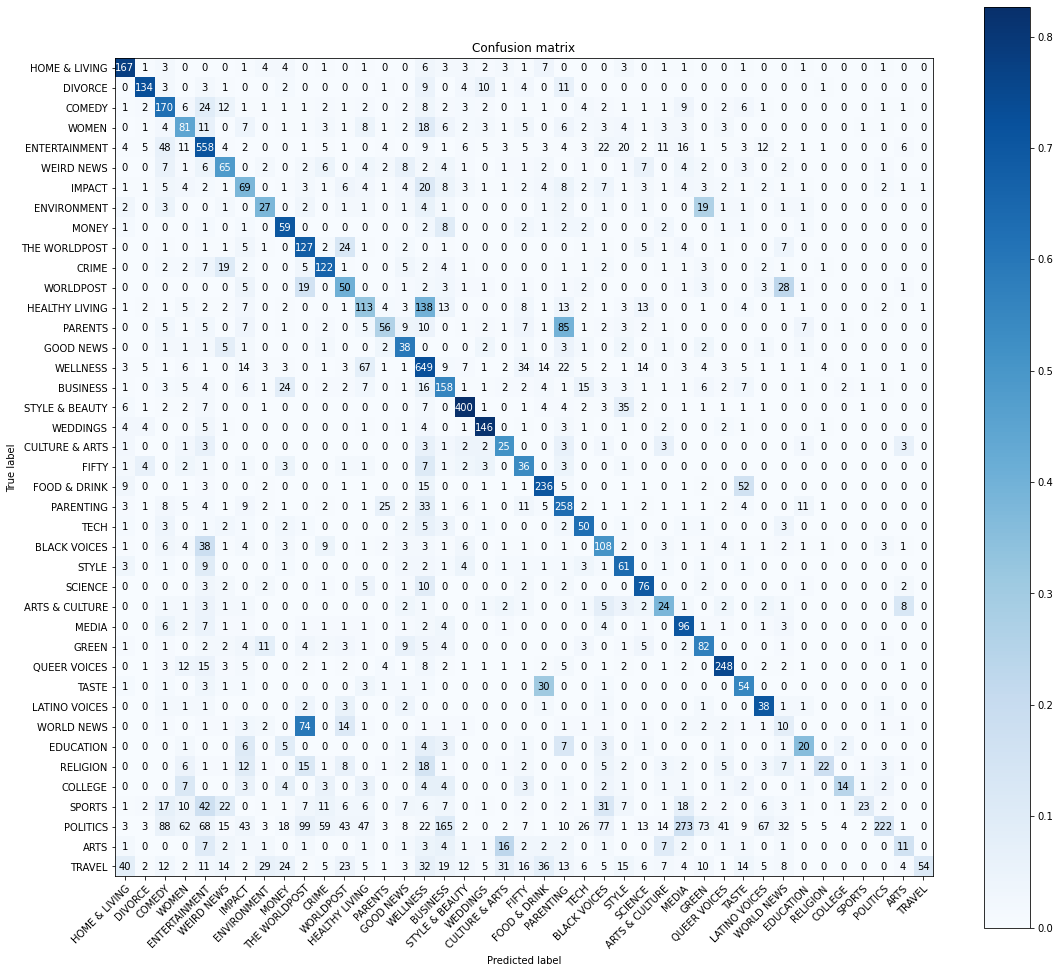

In [16]:
import numpy as np

train_classes_str = list(set(all_classes_str) - set(test_classes_str))

id2label = np.array(train_classes_str + test_classes_str)
label2id = {c: i for i, c in enumerate(id2label)}

y_pred = np.array([label2id[c] for c in all_predictions])
y_true = np.array([label2id[c] for c in all_labels])

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, classes=id2label, normalize=True, figsize=(16, 14))

Confusion matrix results:

* **Arts**, **world news**, and **education** misclassifications look reasonable
* **Politics** misclassifications are very diverse
* Hard to draw any conclusions on other classes (**colledge, sports, religion**, and **travel**) without in-depth error analysis

# Confusion matrix (zero-shot only)

In [ ]:
zso_dataloader = cat.evaluation_utils.make_test_classes_only_dataloader(
    dataset=data["test"],
    test_classes_str=test_classes_str,
    text_tokenizer=train_dataloader.dataset.text_tokenizer,
    label_tokenizer=train_dataloader.dataset.label_tokenizer,
)

In [ ]:
zso_predictions, zso_labels, zso_texts = predict(
    model=model,
    dataloader=zso_dataloader,
    labels_str=test_classes_str,
    device=args.device,
    return_texts=True,
    progress_bar=True,
)

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

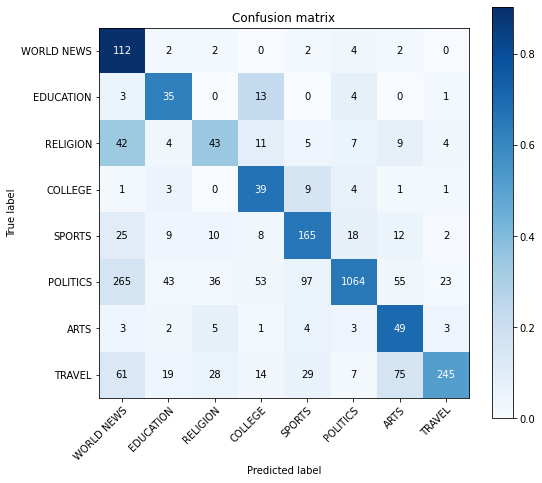

In [19]:
id2label_zso = np.array(test_classes_str)
label2id_zso = {c: i for i, c in enumerate(id2label_zso)}

y_pred = np.array([label2id_zso[c] for c in zso_predictions])
y_true = np.array([label2id_zso[c] for c in zso_labels])

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, classes=id2label_zso, normalize=True, figsize=(8, 7))

In [17]:
zso_metrics = cat.evaluation_utils.evaluate_model(
    model,
    zso_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=None,  # it needs to be None, so that the metrics are not splitted in two subsets
)

In [18]:
zso_metrics['eval/acc']

0.6266094420600858

In [20]:
zso_metrics

{'eval/acc': 0.6266094420600858,
 'eval/P_macro': 0.4691253669030645,
 'eval/R_macro': 0.6337761558367587,
 'eval/F1_macro': 0.4835451351194557,
 'eval_per_class/WORLD NEWS/P': 0.2187499999572754,
 'eval_per_class/EDUCATION/P': 0.29914529888961944,
 'eval_per_class/RELIGION/P': 0.3467741932687305,
 'eval_per_class/COLLEGE/P': 0.28057553936649243,
 'eval_per_class/SPORTS/P': 0.5305466236236184,
 'eval_per_class/POLITICS/P': 0.9576957694907564,
 'eval_per_class/ARTS/P': 0.24137931022592152,
 'eval_per_class/TRAVEL/P': 0.8781362004021016,
 'eval_per_class/WORLD NEWS/R': 0.903225805723205,
 'eval_per_class/EDUCATION/R': 0.6249999988839285,
 'eval_per_class/RELIGION/R': 0.3439999997248,
 'eval_per_class/COLLEGE/R': 0.6724137919441141,
 'eval_per_class/SPORTS/R': 0.6626506021435138,
 'eval_per_class/POLITICS/R': 0.6503667481265056,
 'eval_per_class/ARTS/R': 0.6999999990000001,
 'eval_per_class/TRAVEL/R': 0.5125523011480015,
 'eval_per_class/WORLD NEWS/F1': 0.35220122635971957,
 'eval_per_cla